In [1]:
using CSV
using DataFrames
using JSON
using CairoMakie
using Statistics

In [2]:
function parse_js(path)
    fields = Dict{String,Any}()
    for line in readlines(path)
        if occursin("fileJSON", line)
            continue # Avoiding to load all source files. They're too big for REs.
        end

        matched_line = match(r"var (.+)=(\{.+\});$", line)
        if matched_line === nothing
            continue
        end
        
        name = matched_line[1]
        data = replace(matched_line[2], "\\'" => "'")
        fields[name] = JSON.parse(data)
    end
    return fields
end

parse_js (generic function with 1 method)

In [3]:
function load_details(example, binary_name=example)
    quartus_data = parse_js("build/examples/$(example)/$(binary_name).prj/reports/resources/quartus_data.js")
    f = parse(Float32, quartus_data["quartusJSON"]["quartusFitClockSummary"]["nodes"][1]["kernel clock fmax"]) * 1e6

    report_data = parse_js("build/examples/$(example)/$(binary_name).prj/reports/resources/report_data.js")
    kernels = report_data["loop_attrJSON"]["nodes"]
    loops = Iterators.flatmap(kernel -> kernel["children"], kernels)
    loop_latency = sum(Iterators.map(loop -> parse(Float32, loop["lt"]), loops))

    return f, loop_latency
end

load_details (generic function with 2 methods)

In [4]:
f, loop_latency = load_details("convection")
function model_throughput(res)
    n_gens = 5
    n_subgens = 3
    n_cus = n_gens * n_subgens

    cu_latency = res + 1
    pipeline_latency = n_cus * cu_latency
    n_iterations = pipeline_latency + res^2
    stall_ratio = 0.5
    n_cycles = n_iterations / stall_ratio  + loop_latency
    work = res^2 * n_gens
    work / n_cycles * f
end

model_throughput (generic function with 1 method)

In [5]:
e2e_perf = CSV.read("examples/convection/e2e_perf.csv", DataFrame)
e2e_perf.throughput = 1000.0 .* (e2e_perf.res .^ 2) ./ e2e_perf.runtime

pseudo_transient_perf = CSV.read("examples/convection/pseudo_transient_perf.csv", DataFrame)
pseudo_transient_perf.throughput = pseudo_transient_perf.pseudo_steps .* (pseudo_transient_perf.res .^2) ./ pseudo_transient_perf.runtime

e2e_perf.mean_pseudo_throughput = [mean(pseudo_transient_perf[pseudo_transient_perf.res .== res, :throughput]) for res in e2e_perf.res]

nothing

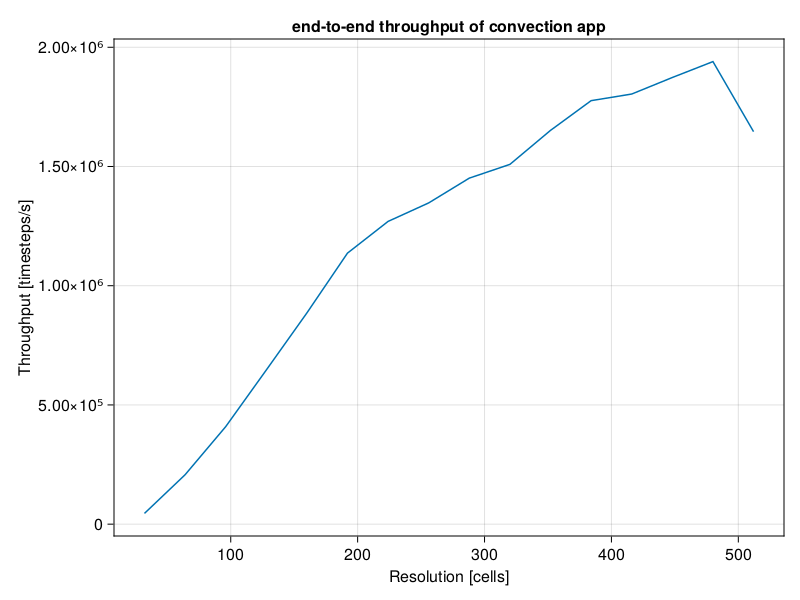

In [6]:
fig, ax, p = lines(e2e_perf.res, 1000.0 .* (e2e_perf.res .^ 2) ./ e2e_perf.runtime)
ax.title = "end-to-end throughput of convection app"
ax.xlabel = "Resolution [cells]"
ax.ylabel = "Throughput [timesteps/s]"
fig

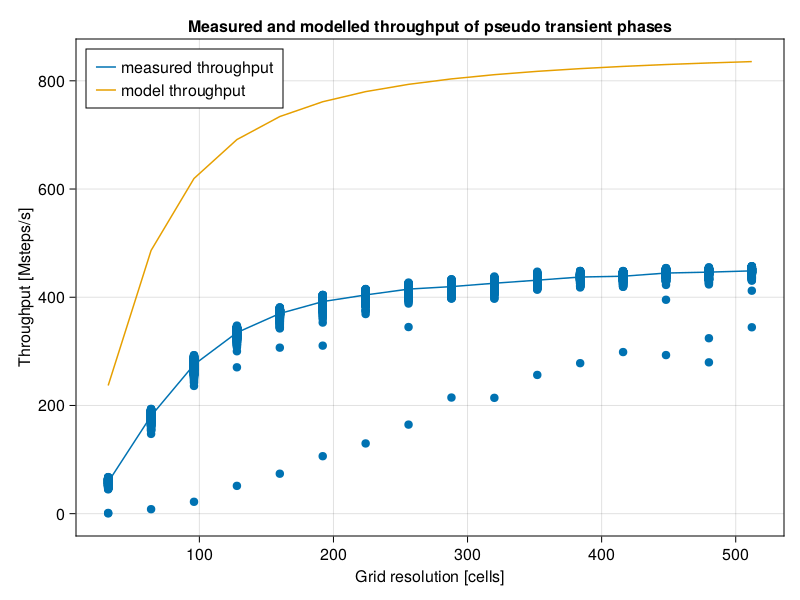

In [7]:
fig, ax, p = lines(e2e_perf.res, e2e_perf.mean_pseudo_throughput .* 1e-6, label="measured throughput")
lines!(ax, e2e_perf.res, model_throughput.(e2e_perf.res) .* 1e-6, label="model throughput")
scatter!(ax, pseudo_transient_perf.res, pseudo_transient_perf.throughput .* 1e-6, pseudo_transient_perf.pseudo_steps)
axislegend(ax, position=:lt)
ax.title = "Measured and modelled throughput of pseudo transient phases"
ax.xlabel = "Grid resolution [cells]"
ax.ylabel = "Throughput [Msteps/s]"
fig